In [2]:
import pandas as pd
import unicodedata
import string
import re
import seaborn as sns
import random

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import nltk
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split,cross_val_score,KFold,GridSearchCV
from sklearn.metrics import precision_recall_curve,precision_score,recall_score,accuracy_score
from sklearn.metrics import plot_confusion_matrix,plot_precision_recall_curve,plot_roc_curve
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn import feature_extraction,naive_bayes,pipeline,manifold,preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import feature_selection

from lime import lime_text
import gensim
import gensim.downloader as gensim_api

# from tensorflow.keras import models,layers,preprocessing as kprocessing
# from tensorflow.keras import backend as K

# import transformers

import numpy as np

/home/ubuntu/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
col_names = ['target','question_title','question_content','best_answer']
target_classes = ['Society & Culture','Science & Mathematics','Health','Education & Reference',
                  'Computers & Internet','Sports','Business & Finance','Entertainment & Music',
                  'Family & Relationships','Politics & Government']
target_classes_dict = {1:'Society & Culture',
                       2:'Science & Mathematics',
                       3:'Health',
                       4:'Education & Reference',
                       5:'Computers & Internet',
                       6:'Sports',
                       7:'Business & Finance',
                       8:'Entertainment & Music',
                       9:'Family & Relationships',
                       10:'Politics & Government'}

In [4]:
df = pd.read_csv('data_yahoo/train.csv',header=None,names=col_names)
# df_test = pd.read_csv('data_yahoo/test.csv',header=None,names=col_names)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   target            1400000 non-null  int64 
 1   question_title    1400000 non-null  object
 2   question_content  768325 non-null   object
 3   best_answer       1375421 non-null  object
dtypes: int64(1), object(3)
memory usage: 42.7+ MB


In [5]:
df.head()

,target,question_title,question_content,best_answer
0,5,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...
1,6,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...
2,3,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...
3,7,How many planes Fedex has?,I heard that it is the largest airline in the ...,according to the www.fedex.com web site:\nAir ...
4,7,"In the san francisco bay area, does it make se...",the prices of rent and the price of buying doe...,renting vs buying depends on your goals. <br /...


In [6]:
def get_samples(df, num_samples):
    idx_lst = list(range(len(df)))
    idx_samps = random.sample(idx_lst, num_samples)
    df_samp = df.iloc[idx_samps]
    return df_samp

### Sampling the dataset since I'm running that on my computer. 
**** NEED to remove that in AWS

In [7]:
df = get_samples(df,200000)

In [8]:
df.question_content.fillna(value='',axis=0,inplace=True)
df.best_answer.fillna(value='',axis=0,inplace=True)

In [9]:
df.shape

(200000, 4)

In [10]:
df['Q'] = df.question_title + df.question_content
df['Q&A'] = df.question_title + df.question_content + df.best_answer

In [11]:
df.head(5)

,target,question_title,question_content,best_answer,Q,Q&A
595033,9,does anyone know any good graduating poems i c...,,yeah i got one im also graduating from high sc...,does anyone know any good graduating poems i c...,does anyone know any good graduating poems i c...
214931,4,why ae electric plugs in different countries d...,,"I think the question is to the shape, size, po...",why ae electric plugs in different countries d...,why ae electric plugs in different countries d...
1181574,6,who do you want/ did you want to win the World...,,England,who do you want/ did you want to win the World...,who do you want/ did you want to win the World...
1340589,1,Why is it funny...?,Why is it funny when brunettes or redheads tel...,it is all in the timing. i have laughed at bl...,Why is it funny...?Why is it funny when brunet...,Why is it funny...?Why is it funny when brunet...
79330,5,Where can i get winzip 7.0?,,You can get winzip 7.0 easy. All the other ve...,Where can i get winzip 7.0?,Where can i get winzip 7.0?You can get winzip ...


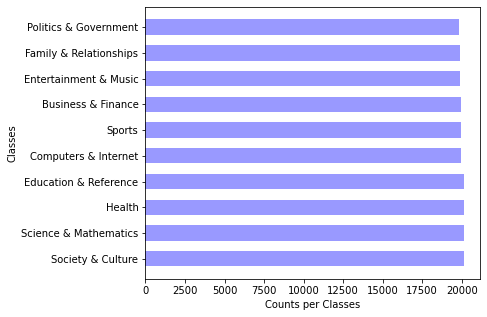

In [12]:
fig,ax = plt.subplots(figsize=(6,5));
ax.barh(y = target_classes,width=df.target.value_counts().values,color='b',alpha=0.4,height=0.6);
ax.set_ylabel('Classes');
ax.set_xlabel('Counts per Classes');

In [13]:
# df['lang'] = df['Q&A'].apply(lambda x:langdetect.detect(x) if x.strip()!="" else "")

In [14]:
lst_stopwords = stopwords.words('english')

In [15]:
def text_cleaning(text,stem_flag=False,lem_flag=True,lst_stopwords=None):
    text = text.replace('\\n',' ')
    text = text.replace('\n',' ')
    text = re.sub(r'[^\w\s]',' ',str(text).lower().strip())
    text = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", str(text).lower().strip())
    text = re.sub(' 0 ',' ',str(text).lower().strip())
    text = re.sub(' 00 ',' ',str(text).lower().strip())
    text = re.sub(' 000 ',' ',str(text).lower().strip())
    
    lst_text = text.split()
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
    if stem_flag == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
    if lem_flag == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
    lst_text = " ".join(lst_text)
    return lst_text

In [16]:
df['Text_new'] = df['Q&A'].apply(lambda x:text_cleaning(x,stem_flag=False,lem_flag=True,lst_stopwords=lst_stopwords))

In [17]:
df.head(10)

,target,question_title,question_content,best_answer,Q,Q&A,Text_new
595033,9,does anyone know any good graduating poems i c...,,yeah i got one im also graduating from high sc...,does anyone know any good graduating poems i c...,does anyone know any good graduating poems i c...,anyone know good graduating poem could send ne...
214931,4,why ae electric plugs in different countries d...,,"I think the question is to the shape, size, po...",why ae electric plugs in different countries d...,why ae electric plugs in different countries d...,ae electric plug different country different t...
1181574,6,who do you want/ did you want to win the World...,,England,who do you want/ did you want to win the World...,who do you want/ did you want to win the World...,want want win world cup england
1340589,1,Why is it funny...?,Why is it funny when brunettes or redheads tel...,it is all in the timing. i have laughed at bl...,Why is it funny...?Why is it funny when brunet...,Why is it funny...?Why is it funny when brunet...,funny funny brunette redhead tell blonde joke ...
79330,5,Where can i get winzip 7.0?,,You can get winzip 7.0 easy. All the other ve...,Where can i get winzip 7.0?,Where can i get winzip 7.0?You can get winzip ...,get winzip get winzip easy version http www ol...
1398956,10,which stat in USA good for refugee?,,Contact a US Embassy near you or look at one o...,which stat in USA good for refugee?,which stat in USA good for refugee?Contact a ...,stat usa good refugee contact u embassy near l...
580243,3,Do you talk to your computer?,I mean like talk to it like it understands you...,well i ask it one question most of the time......,Do you talk to your computer?I mean like talk ...,Do you talk to your computer?I mean like talk ...,talk computer mean like talk like understands ...
470763,5,"when I answer a Yahoo question, At the end it ...",Does anyone know why? Its only in the past 24 ...,"Anytime you answer a question, it will display...","when I answer a Yahoo question, At the end it ...","when I answer a Yahoo question, At the end it ...",answer yahoo question end started say edit del...
999698,4,Theres a saying that goes if nothing is broken...,im trying to explain that if something works f...,"""If it's not broke, don't fix it.""\n\n""Leave w...",Theres a saying that goes if nothing is broken...,Theres a saying that goes if nothing is broken...,there saying go nothing broken fix go worded d...
257183,4,Do you guys know any colleges where you can go...,i am still doing my reaport and i have no idea...,"In Virginia, I think University of Virginia, J...",Do you guys know any colleges where you can go...,Do you guys know any colleges where you can go...,guy know college go want teacher still reaport...


In [18]:
df['word_count'] = df['Q&A'].apply(lambda x:len(str(x).split(" ")))
df['char_count'] = df['Q&A'].apply(lambda x: sum(len(word)for word in str(x).split(" ")))
df['sentence_count'] = df['Q&A'].apply(lambda x:len(str(x).split(".")))
df['word_length'] = df['char_count']/df['word_count']
df['word_per_sentence'] = df['word_count']/df['sentence_count']

In [19]:
df.head(2)

,target,question_title,question_content,best_answer,Q,Q&A,Text_new,word_count,char_count,sentence_count,word_length,word_per_sentence
595033,9,does anyone know any good graduating poems i c...,,yeah i got one im also graduating from high sc...,does anyone know any good graduating poems i c...,does anyone know any good graduating poems i c...,anyone know good graduating poem could send ne...,95,442,8,4.652632,11.875000
214931,4,why ae electric plugs in different countries d...,,"I think the question is to the shape, size, po...",why ae electric plugs in different countries d...,why ae electric plugs in different countries d...,ae electric plug different country different t...,65,388,11,5.969231,5.909091


In [20]:
colors=['b','g','r','k','magenta','orange','aqua','violet','peachpuff','pink']
len(colors)

10

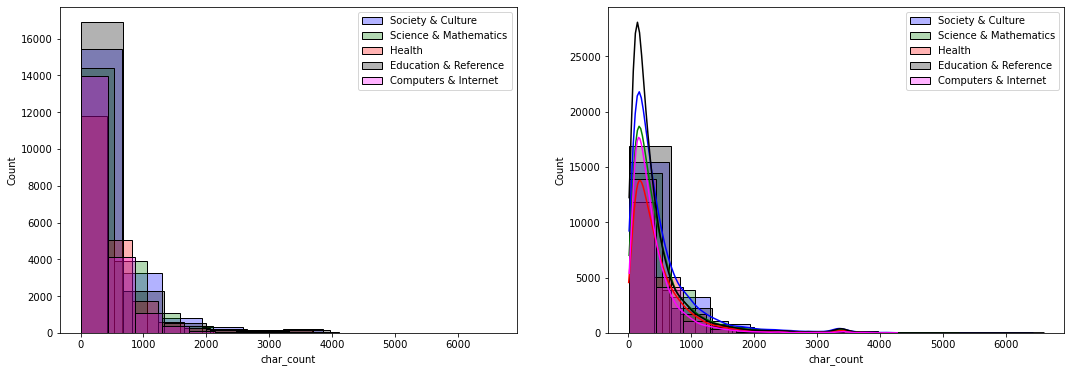

In [21]:
plt_list = ['word_count','char_count','sentence_count','word_length','word_per_sentence']
fig,ax = plt.subplots(1,2,figsize=(18,6))
for i in range(5):#df.target.unique():
    sns.histplot(df[df.target==i+1][plt_list[1]],kde=False,bins=10,ax=ax[0],alpha=0.3,color=colors[i],label=target_classes[i]);
    sns.histplot(df[df.target==i+1][plt_list[1]],kde=True,bins=10,ax=ax[1],alpha=0.3,color=colors[i],label=target_classes[i]);
ax[0].legend();
ax[1].legend();
plt.show();

In [22]:
df.groupby('target').word_count.median()

target
1     71
2     66
3     75
4     53
5     60
6     45
7     53
8     41
9     76
10    72
Name: word_count, dtype: int64

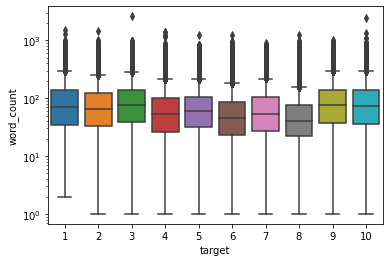

In [23]:
ax = sns.boxplot(x="target", y="word_count", data=df)
ax.set_yscale('log')

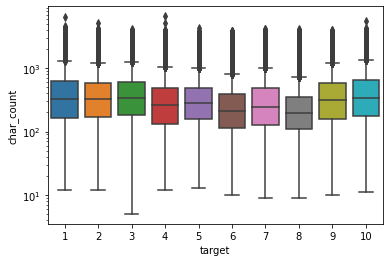

In [24]:
ax = sns.boxplot(x="target", y="char_count", data=df)
ax.set_yscale('log')

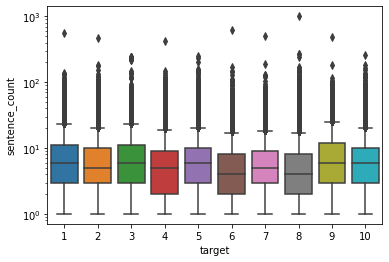

In [25]:
ax = sns.boxplot(x="target", y="sentence_count", data=df)
ax.set_yscale('log')

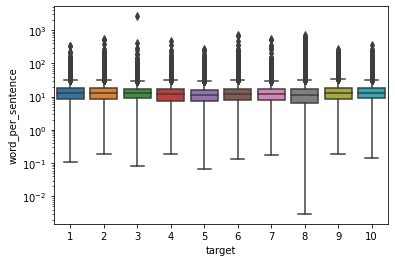

In [26]:
ax = sns.boxplot(x="target", y="word_per_sentence", data=df)
ax.set_yscale('log')

### Tf-idf Method for text classification

In [27]:
X = df.Text_new
y = df.target

In [28]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=0.1,random_state=20)

In [29]:
vect = TfidfVectorizer(max_features=5000,ngram_range=(1,2))

In [30]:
XX_train = vect.fit_transform(X_train)

In [31]:
XX_test = vect.transform(X_test)

In [32]:
vocab = vect.vocabulary_

In [33]:
# sns.heatmap(XX_train.todense()[:,np.random.randint(0,XX_train.shape[1],100)]==0 , vmin=0 , vmax=1,cbar=False).set_title('Sample of Sparse Matrix');

In [34]:
X_names = vect.get_feature_names()
df_features = pd.DataFrame()
for category in np.unique(y_train):
    chi2,p = feature_selection.chi2(XX_train,y_train==category)
    df_features = df_features.append(pd.DataFrame({'feature':X_names,'Score':1-p,"y":category}))
    df_features = df_features.sort_values(["y","Score"],ascending=[True,False])
    df_features = df_features[df_features.Score>0.95]

X_names_unique = df_features.feature.unique().tolist()
len(X_names_unique)

4755

In [35]:
df_features.head(5)

,feature,Score,y
49,accent,1.0,1
76,adam,1.0,1
135,allah,1.0,1
182,angel,1.0,1
255,arabic,1.0,1


In [36]:
for category in np.unique(y_train):
    print(f'category {category}:',target_classes[category-1])
    print(f'length of category {category}:',len(df_features[df_features.y==category]))
    print(",".join(df_features[df_features.y==category].feature[:30]))
    print("")

category 1: Society & Culture
length of category 1: 1730
accent,adam,allah,angel,arabic,asian,atheist,belief,believe,believe god,believer,believing,bible,bible say,black,blessed,blessing,catholic,catholic church,celebrate,christ,christian,christianity,christmas,church,com,commandment,computer,created,creation

category 2: Science & Mathematics
length of category 2: 2595
2x,3x,4x,5x,acceleration,acid,air,algebra,amino,amount,angle,animal,atmosphere,atom,atomic,axis,bacteria,bang,base,beam,best,big bang,billion,biology,bird,black hole,boiling,bond,brain,calcium

category 3: Health
length of category 3: 2341
ab,acne,affect,aid,alcohol,allergic,allergy,ankle,antibiotic,anxiety,appointment,arm,artery,avoid,bacteria,bad,bath,bed,belly,bipolar,birth control,bladder,bleeding,blood,blood pressure,body,bone,brace,brain,breast

category 4: Education & Reference
length of category 4: 1394
academic,admission,art,author,bachelor,book,campus,class,classroom,college,community college,course,degree,dic

In [37]:
vect = TfidfVectorizer(vocabulary=X_names_unique)

In [38]:
XX_train = vect.fit_transform(X_train)
XX_train.shape

(180000, 4755)

In [39]:
XX_test = vect.transform(X_test)

In [40]:
# sns.heatmap(XX_train.todense()[:,np.random.randint(0,XX_train.shape[1],100)]==0 , vmin=0 , vmax=1,cbar=False).set_title('Sample of Sparse Matrix');

In [41]:
# Creating a cloud of words

In [42]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis('off')

In [43]:
Text = " ".join(df_features[df_features.y==6].feature[:30])
Text

'allen argentina arsenal athlete atlanta au australia ball baseball basketball bat bay beat ben bench best bike boston bowl boxing brazil captain ce cena champion championship chelsea chicago club coach'

In [44]:
wordcloud = WordCloud(width=1000,height=880,random_state=1,background_color='black',colormap='Set2',
                      collocations=False,stopwords=lst_stopwords).generate(Text)

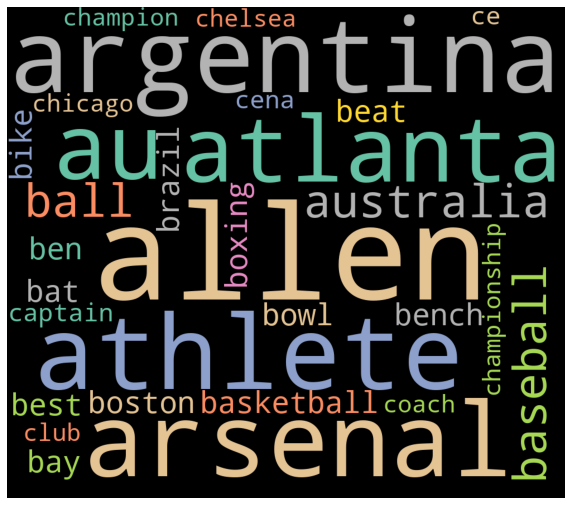

In [45]:
plot_cloud(wordcloud)

In [46]:
cvec = CountVectorizer(max_features=5000, ngram_range=(1, 2),stop_words='english')

In [47]:
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec  = cvec.transform(X_test)

### Naive Bayes Classifier
In this section, we used Naive bayes classifer to fit our model to training data

In [48]:
nb = naive_bayes.MultinomialNB()

In [49]:
# # pipeline
# model = pipeline.Pipeline([("vectorizer",vect),
#                            ("classifier",nb)])

In [50]:
cross_val_score(nb,XX_train,y_train,cv=5,n_jobs=-1).mean()

0.6634555555555556

In [51]:
# Train Classifier
#model['classifier'].fit(XX_train,y_train)
nb.fit(XX_train,y_train)

MultinomialNB()

In [52]:
## Test Classifier
Predicted = nb.predict(XX_test)
Predicted_prob = nb.predict_proba(XX_test)

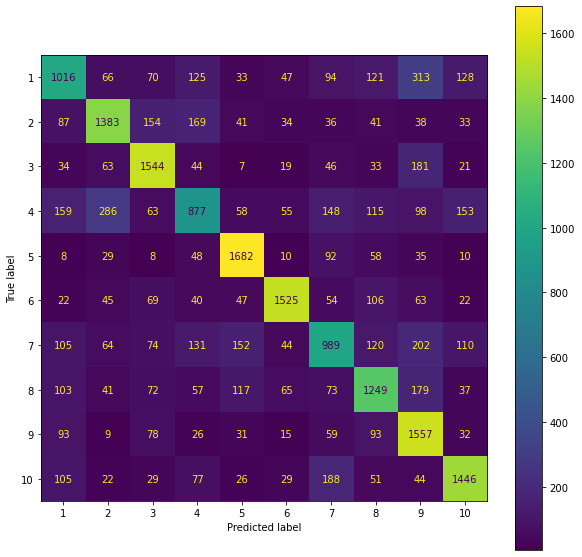

In [53]:
fig, ax = plt.subplots(figsize=(10, 10));
plot_confusion_matrix(nb,XX_test,y_test,ax=ax);

In [54]:
cross_val_score(nb,X_train_cvec,y_train,cv=5,n_jobs=-1).mean()

0.6567000000000001

### Logistic Regression Classifier
In this section, we used logistic classifer to fit our model to training data

In [55]:
model_lr = LogisticRegression(max_iter=5000)

In [56]:
# # pipeline
# model_lr = pipeline.Pipeline([("vectorizer",vect),
#                            ("classifier",lr)])

In [57]:
cross_val_score(model_lr,XX_train,y_train,cv=5,n_jobs=-1).mean()

0.6774666666666667

In [58]:
# Train Classifier
#model['classifier'].fit(XX_train,y_train)
model_lr.fit(XX_train,y_train)

LogisticRegression(max_iter=5000)

In [59]:
## Test Classifier
Predicted = model_lr.predict(XX_test)
Predicted_prob = model_lr.predict_proba(XX_test)

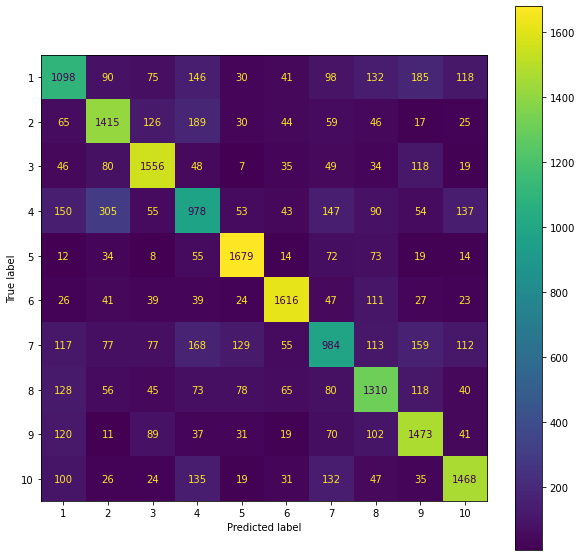

In [60]:
fig, ax = plt.subplots(figsize=(10, 10));
plot_confusion_matrix(model_lr,XX_test,y_test,ax=ax);

### Random Forest Classifier
In this section, we will use random forest classiier to fit our model to the training dataset

In [84]:
model_rf = RandomForestClassifier(n_estimators=2000,max_depth=30,n_jobs=-1)

In [85]:
# # pipeline
# model_rf = pipeline.Pipeline([("vectorizer",vect),
#                               ("classifier",rf)])

In [86]:
cross_val_score(model_rf,XX_train,y_train,cv=5,n_jobs=-1).mean()

0.5585888888888888

In [87]:
model_rf.fit(XX_train,y_train)

RandomForestClassifier(max_depth=30, n_estimators=2000, n_jobs=-1)

In [88]:
## Test Classifier
Predicted_rf = model_rf.predict(XX_test)
Predicted_prob_rf = model_rf.predict_proba(XX_test)

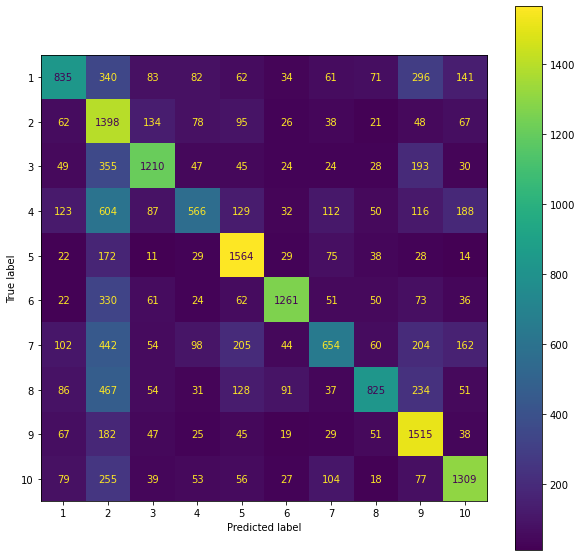

In [89]:
fig, ax = plt.subplots(figsize=(10, 10));
plot_confusion_matrix(model_rf,XX_test,y_test,ax=ax);

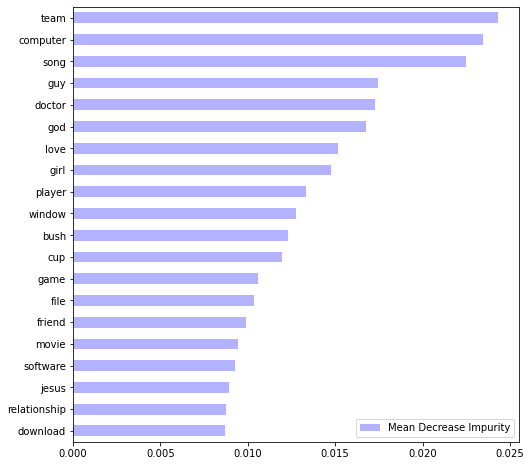

In [90]:
feature_names = list(X_names_unique)
feature_scores = pd.DataFrame({'Mean Decrease Impurity' : model_rf.feature_importances_}, index=feature_names)
feature_scores = feature_scores.sort_values(by='Mean Decrease Impurity', ascending=False)[:20]
feature_scores.plot(kind='barh', color = 'b', alpha=0.3, figsize=(8,8))
ax = plt.gca().invert_yaxis()
leg = plt.legend( loc = 'lower right')

In [68]:
classes = np.unique(y_test)
y_test_dummy = pd.get_dummies(y_test).values

accuracy = accuracy_score(y_test,Predicted)
auc = roc_auc_score(y_test,Predicted_prob,multi_class='ovr')

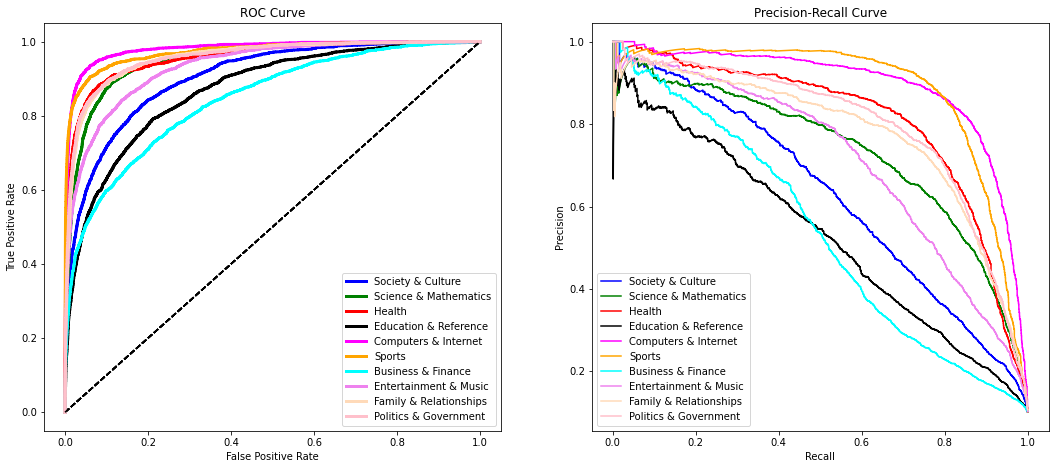

In [69]:
fig,axs = plt.subplots(1,2,figsize=(18,7.5))
for i in range(10):
    # ROC Curve
    fpr,tpr,thresholds = roc_curve(y_test_dummy[:,i],Predicted_prob[:,i])
    axs[0].plot(fpr,tpr,lw=3,label=target_classes[i],color=colors[i])
    axs[0].plot([0,1],[0,1],color='k',ls='--')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].legend()
    axs[0].set_title('ROC Curve')
    # Precision-Recall Curve
    precision,recall,thresholds = precision_recall_curve(y_test_dummy[:,i],Predicted_prob[:,i])
    axs[1].plot(recall,precision,label=target_classes[i],color=colors[i])
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].set_title('Precision-Recall Curve')
    axs[1].legend()
    

### GridSearch CV

In [1]:
opt_model = pipeline.Pipeline([
           ('vectopt', TfidfVectorizer()),
           ('classifier', model_lr)])

NameError: name 'pipeline' is not defined

In [95]:
parameters = {
    'vectopt__max_df': [0.85, 0.9, 1.0],
    'vectopt__min_df': (0.01, 0.05 , 0.1),
    'vectopt__max_features': (2000, 5000, 10000),
    'vectopt__ngram_range': ((1, 1), (1, 2), (1,3))  
                }

In [96]:
lr_gs = GridSearchCV(opt_model,param_grid=parameters,cv=5,verbose=1,n_jobs=-1,scoring='accuracy')

In [ ]:
lr_gs.fit(X_train,y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 72 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.5min


In [90]:
pd.DataFrame(lr_gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_vectopt__max_features,param_vectopt__min_df,param_vectopt__ngram_range,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,19.097728,0.742725,3.290995,0.422751,2000,0.01,"(1, 1)","{'vectopt__max_features': 2000, 'vectopt__min_...",0.561711,0.558511,0.560111,0.001600,7
1,36.380887,1.920778,5.687738,0.050658,2000,0.01,"(1, 2)","{'vectopt__max_features': 2000, 'vectopt__min_...",0.562378,0.558600,0.560489,0.001889,1
2,59.586514,0.385229,8.155517,0.158291,2000,0.01,"(1, 3)","{'vectopt__max_features': 2000, 'vectopt__min_...",0.562378,0.558600,0.560489,0.001889,1
3,8.038393,0.180106,2.718961,0.094096,2000,0.05,"(1, 1)","{'vectopt__max_features': 2000, 'vectopt__min_...",0.290656,0.290611,0.290633,0.000022,10
4,29.951579,0.026987,5.490009,0.006739,2000,0.05,"(1, 2)","{'vectopt__max_features': 2000, 'vectopt__min_...",0.290467,0.290733,0.290600,0.000133,13
5,58.905851,0.564803,7.710863,0.025881,2000,0.05,"(1, 3)","{'vectopt__max_features': 2000, 'vectopt__min_...",0.290467,0.290733,0.290600,0.000133,13
6,5.427804,0.028343,3.633741,0.636224,2000,0.1,"(1, 1)","{'vectopt__max_features': 2000, 'vectopt__min_...",0.203689,0.204122,0.203906,0.000217,19
7,22.768734,0.480399,5.995760,0.497403,2000,0.1,"(1, 2)","{'vectopt__max_features': 2000, 'vectopt__min_...",0.203689,0.204122,0.203906,0.000217,19
8,51.713783,1.679529,7.804711,0.024270,2000,0.1,"(1, 3)","{'vectopt__max_features': 2000, 'vectopt__min_...",0.203689,0.204122,0.203906,0.000217,19
9,22.398217,1.872304,3.442624,0.367029,5000,0.01,"(1, 1)","{'vectopt__max_features': 5000, 'vectopt__min_...",0.561711,0.558511,0.560111,0.001600,7


### USE THE BELOW LINES FOR DEBUGGING

In [70]:
lr_test = LogisticRegression(max_iter=5000)
# pipeline
model_test = pipeline.Pipeline([("vectorizer",vect),
                                ("classifier",lr_test)])
model_test.fit(X_train,y_train)
## Test Classifier
Predicted_test = model_test.predict(X_test)
Predicted_prob_test = model_test.predict_proba(X_test)

In [71]:
# Testing the error
X_test[y_test!=Predicted].iloc[1]
y_test[y_test!=Predicted]
e = Predicted[y_test!=Predicted]
index_incorrect = X_test[(y_test!=Predicted) & (y_test==7)].index
index_incorrect

Int64Index([  60357,  224771,   85369,  186768,  820393,  273361,   19816,
            1072704,  297522, 1309975,
            ...
              26571,  101234,  301231,  147787,   59007,  281576,   91956,
             689499, 1281101,  161366],
           dtype='int64', length=1066)

In [72]:
X_test[(y_test!=Predicted) & (y_test==7)]

60357      think blind people would enjoy rubiks cube bra...
224771     become thief career steal greatest thief escap...
85369                                    old work mall least
186768     job description call center tell job descripti...
820393     one isfresher networking ccna certification st...
                                 ...                        
281576     anyone know give cyclone name nowadays cyclone...
91956      know island mauritius say paradise earth servi...
689499     get dow stock page new page idea many thousand...
1281101    write briefly note following portifolio adjust...
161366     looking tea set mark noritake wreath middle ja...
Name: Text_new, Length: 1066, dtype: object

In [75]:
X_test.loc[689499]

'get dow stock page new page idea many thousand differnt program page different way display dow take blinder page talking page different page'

In [76]:
df.loc[689499]['Q&A']

'how do i get dow stock page on this new page?Do you have any idea how many thousands of differnt programs and "pages" and different ways you can display the Dow? Take off the blinders.\\n\\nWhich "page" are you talking about and how is "this" page different from that page?'

In [91]:
test_set = 55
text = X_test.iloc[test_set]
text

'moral fiber religious cereal'

In [92]:
# print('Actual class -->',y_test.iloc[test_set],'|     Predicted class is -->',Predicted_test[test_set],
#       '|     Probability -->  ',np.max(Predicted_prob_test[test_set]))
print('Actual class -->',target_classes[y_test.iloc[test_set]-1])
print('Predicted class -->',target_classes[Predicted[test_set]-1])

Actual class --> Society & Culture
Predicted class --> Society & Culture


In [93]:
# explainer = lime_text.LimeTextExplainer(class_names=np.unique(y_train))
explainer = lime_text.LimeTextExplainer(class_names=target_classes)

In [96]:
explained = explainer.explain_instance(text,model_test.predict_proba,num_features=5,top_labels=1)

In [97]:
explained.show_in_notebook(text=text,predict_proba=True)

In [ ]:
gg = model_lr.predict(XX_train)

In [83]:
index_incorrect_train = X_train[(gg!=y_train) & (y_train==7)].index
index_incorrect_train

Int64Index([ 271576,  243888,  169166,  214536,  292844,  222682,   47090,
              37687,  222786,  681340,
            ...
             668425,  488084, 1081824,  217417,  460831,   30397, 1397152,
             192470,   16529, 1021465],
           dtype='int64', length=8743)

In [ ]:
g = df[df.target==7]
g.head()

In [ ]:
# sum_=0
# lst=[]
# lst2=[]
# for i,text in enumerate(g.Text_new):
#     if 'acid' in text:
#         sum_ +=1
#         lst.append(text)
#         lst2.append(i)